Pairs Trading
- Find 2 stocks with high correlation.
- If deviated from correlation, the opportunity to enter arises.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

In [8]:
def get_historical_data(tickers, start_date, end_date=None):
    """
    Fetch historical stock data for the given tickers.
    """
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')
    adj_close = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers})
    return adj_close

# Separate tickers by sector to avoid correlation bias
tech_tickers = ["MSFT", "AAPL", "GOOGL", "AMZN", "TSLA", "META", "NVDA", "AMD"]
health_tickers = ["ABT", "ABBV", "A", "ALGN", "AMGN", "BAX", "BDX", "TECH", "BIIB", "BSX"]
energy_tickers =  ["XOM", "CVX", "COP", "SLB", "EOG", "PSX", "MPC", "VLO", "HAL", "KMI"]

# Fetch data for each sector separately
tech_close = get_historical_data(tech_tickers, start_date='2022-01-01')
health_close = get_historical_data(health_tickers, start_date='2022-01-01')
energy_close = get_historical_data(energy_tickers, start_date='2022-01-01')

print("Tech stocks data:")
print(tech_close.tail(5))
print("\nHealth stocks data:")
print(health_close.tail(5))
print("\nEnergy stocks data:")
print(energy_close.tail(5))

/var/folders/3l/nqx4k_hj58189kq19rmdpvwr0000gn/T/ipykernel_43953/2134784577.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')
[*********************100%***********************]  8 of 8 completed
/var/folders/3l/nqx4k_hj58189kq19rmdpvwr0000gn/T/ipykernel_43953/2134784577.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')
[**********            20%                       ]  2 of 10 completed
/var/folders/3l/nqx4k_hj58189kq19rmdpvwr0000gn/T/ipykernel_43953/2134784577.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')
[*********************100%***********************]  10 of 10 completed
/var/folders/3l/nqx4k_hj58189kq19rmdpvwr0000gn/T/ipykernel_43953/21

Tech stocks data:
                  MSFT        AAPL       GOOGL        AMZN        TSLA  \
Date                                                                     
2025-11-17  506.541931  267.459991  285.019989  232.869995  408.920013   
2025-11-18  492.867554  267.440002  284.279999  222.550003  401.250000   
2025-11-19  486.209991  268.559998  292.809998  222.690002  403.989990   
2025-11-20  478.429993  266.250000  289.450012  217.139999  395.230011   
2025-11-21  472.119995  271.489990  299.660004  220.690002  391.089996   

                  META        NVDA         AMD  
Date                                            
2025-11-17  602.010010  186.600006  240.520004  
2025-11-18  597.690002  181.360001  230.289993  
2025-11-19  590.320007  186.520004  223.550003  
2025-11-20  589.150024  180.639999  206.020004  
2025-11-21  594.250000  178.880005  203.779999  

Health stocks data:
                   ABT        ABBV           A        ALGN        AMGN  \
Date                     

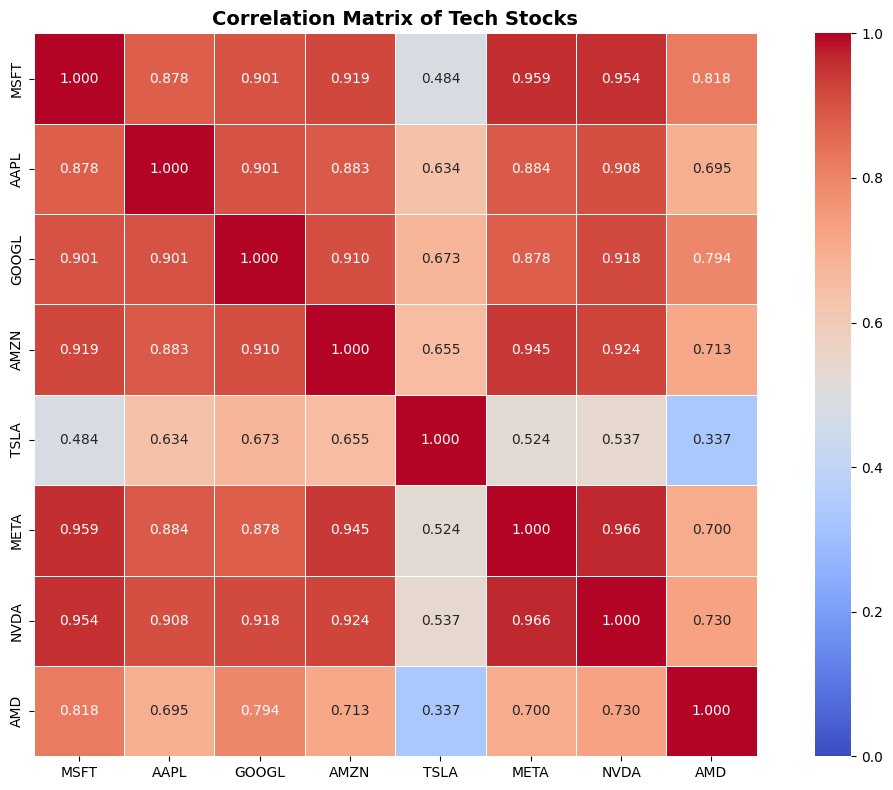

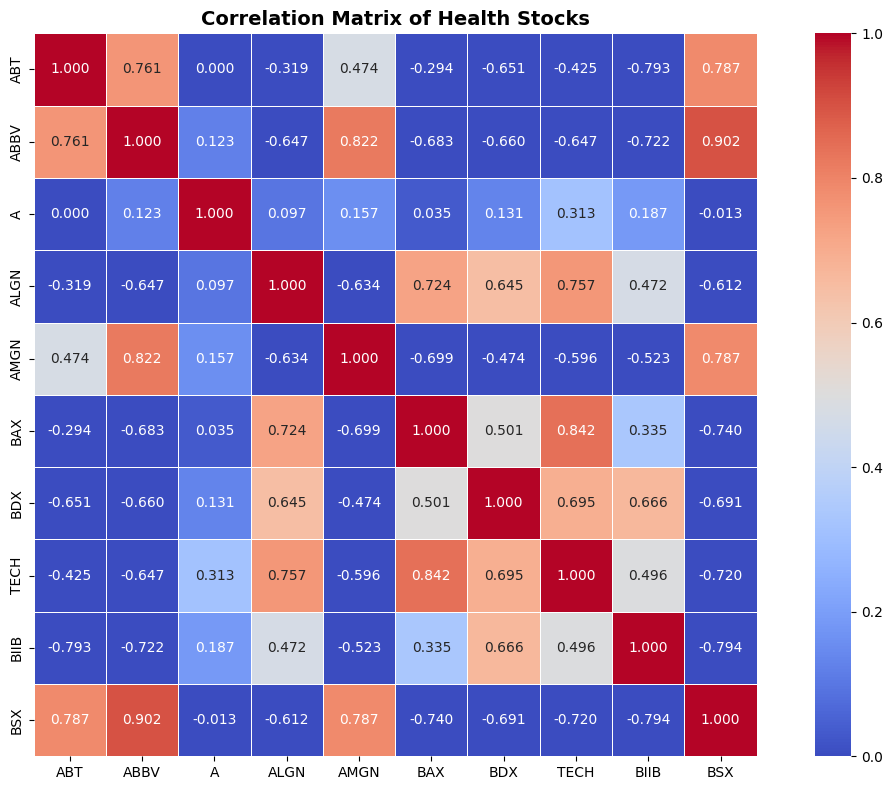

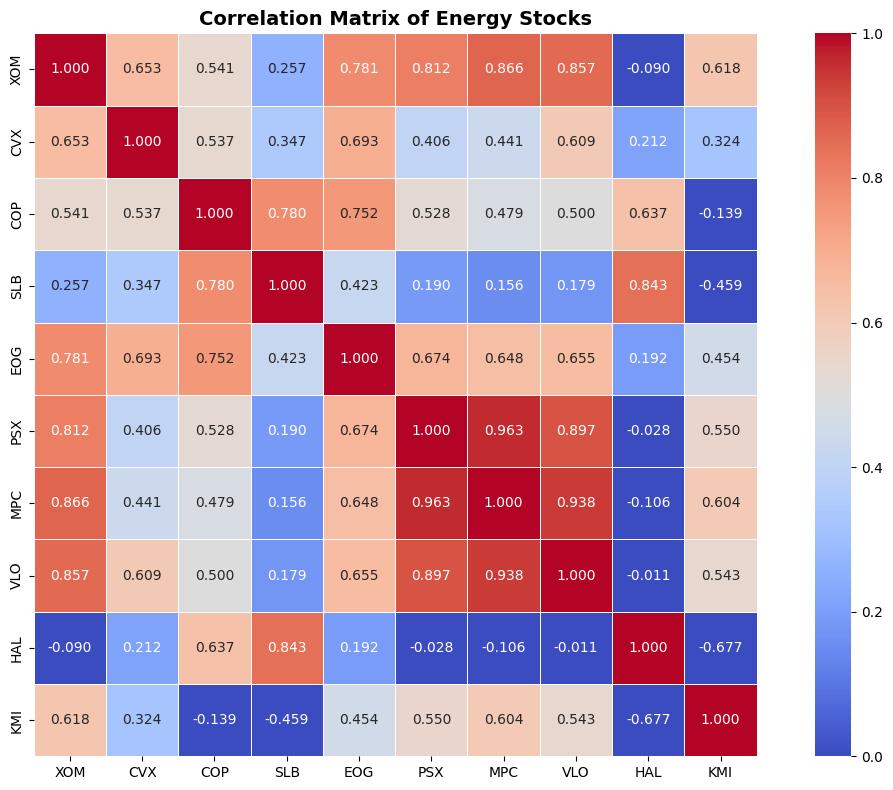

In [9]:
def plot_correlation_heatmap(price_data, title, figsize=(12, 8)):
    """
    Plot a correlation heatmap for the given price data.
    
    Parameters:
    - price_data: DataFrame with stock prices
    - title: Title for the heatmap
    - figsize: Figure size (width, height)
    """
    corr_matrix = price_data.corr()
    
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f", 
                vmin=0, vmax=1, square=True, linewidths=0.5)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

# Generate heatmaps for both sectors
tech_corr = plot_correlation_heatmap(tech_close, 'Correlation Matrix of Tech Stocks')
health_corr = plot_correlation_heatmap(health_close, 'Correlation Matrix of Health Stocks')
energy_corr = plot_correlation_heatmap(energy_close, 'Correlation Matrix of Energy Stocks')

Here we can see that amongst the 3 sectors (tech, health and energy), a lot of tech stocks are highly correlated with one another.
Health not so much (with exception of ABBV/BSX and BAX/TECH).
Energy seems to have a mix of both.
We shall go ahead with energy sector first with cointegration intial testing.

My strategy now is to plot out the highest correlation pairs in the energy sector and look at these criterias:
- Many intersections (more opportunites for trade)
- Price difference is small (Pratical beta values)

In [10]:
def plot_pair_comparison(price_data, ticker1, ticker2, figsize=(14, 6)):
    """
    Plot price series comparison for two stocks.
    
    Parameters:
    - price_data: DataFrame with stock prices
    - ticker1: First stock ticker symbol
    - ticker2: Second stock ticker symbol
    - figsize: Figure size (width, height)
    """
    plt.figure(figsize=figsize)
    
    stock1 = price_data[ticker1]
    stock2 = price_data[ticker2]
    
    plt.plot(stock1, label=ticker1, color='blue', linewidth=2)
    plt.plot(stock2, label=ticker2, color='orange', linewidth=2)
    
    plt.title(f'Price Series of {ticker1} and {ticker2}', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
    
    plt.tight_layout()
    plt.show()

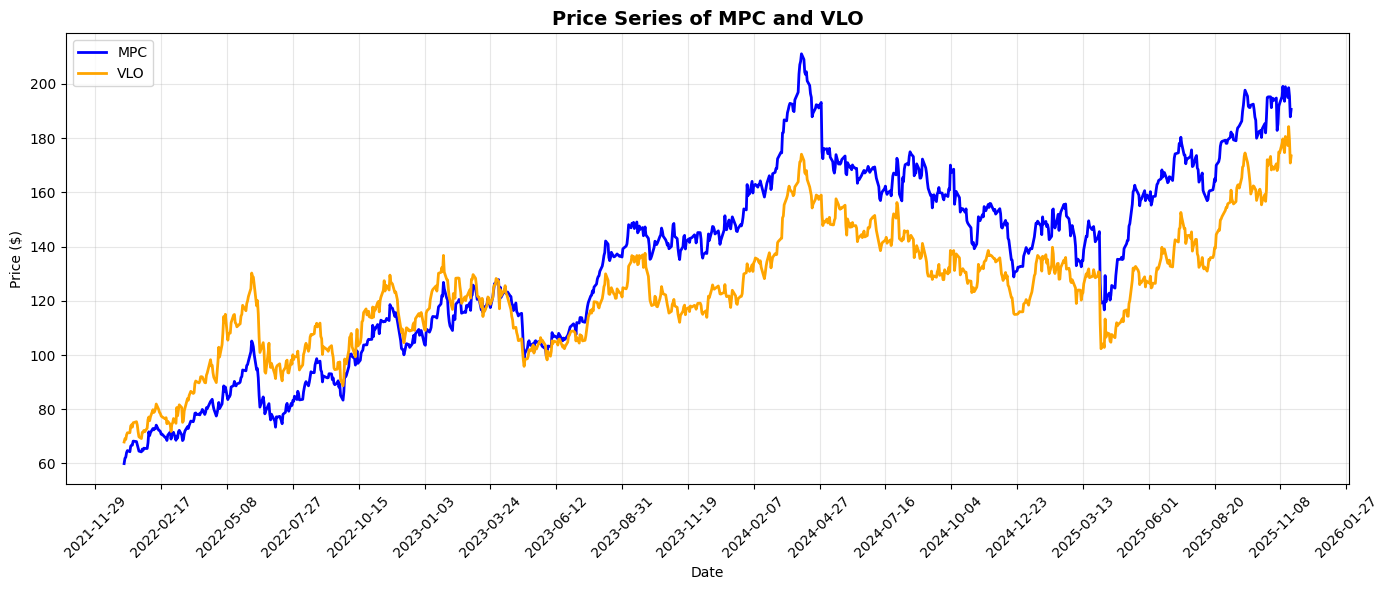

In [11]:

# Test with MPC and VLO
plot_pair_comparison(energy_close, 'MPC', 'VLO')

This satisfies low β, however this pair dosen't seem to have many intersections. From 2021 to 2023 it seemed to have more interssections, but after both stocks had almost 0 intersections. 
Lets choose a better pair.

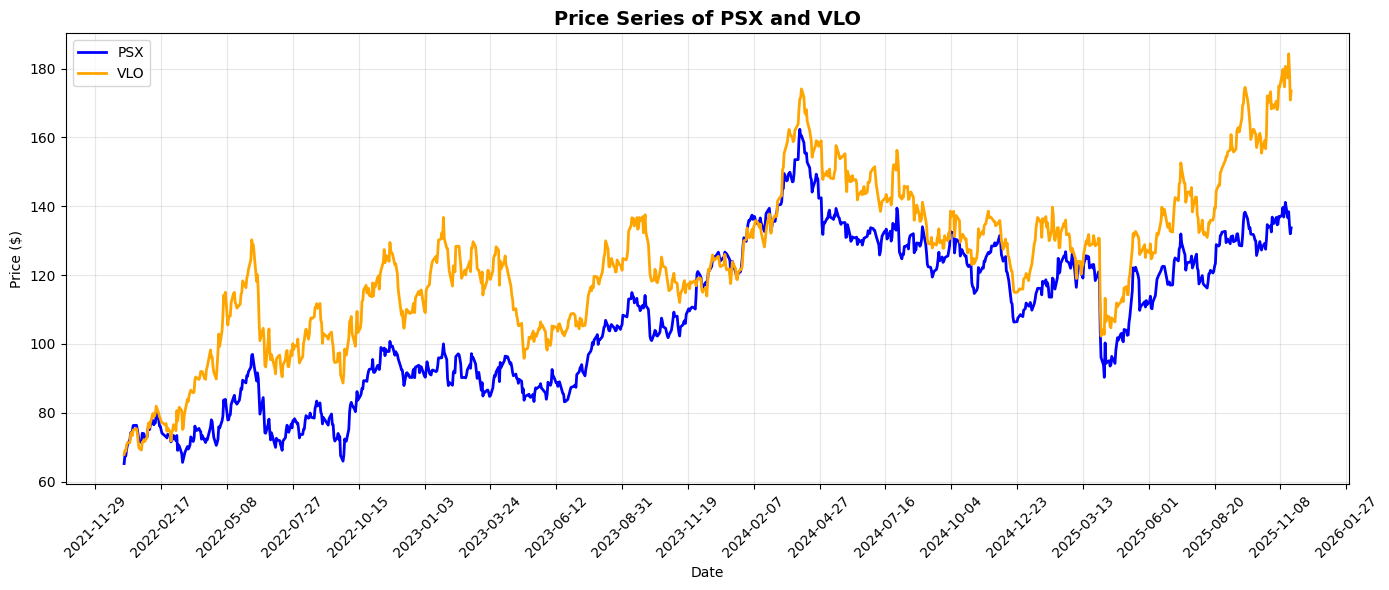

In [12]:
plot_pair_comparison(energy_close, 'PSX', 'VLO')

This is better, we can see from 2023 onwards seems to have more intersectons.
But in more recent times 2025-11-08 it seems to be diverging more.

In [13]:
# Find top 6 highest correlated pairs in energy sector
pairs_list = []
tickers = energy_close.columns.tolist()

for i in range(len(tickers)):
    for j in range(i+1, len(tickers)):
        corr_value = energy_corr.iloc[i, j]
        pairs_list.append({
            'Stock 1': tickers[i],
            'Stock 2': tickers[j],
            'Correlation': corr_value
        })

# Sort by correlation and get top 6
pairs_df = pd.DataFrame(pairs_list).sort_values('Correlation', ascending=False)
top_6_pairs = pairs_df.head(6)

print("🔝 TOP 6 HIGHEST CORRELATED PAIRS IN ENERGY SECTOR:\n")
print(top_6_pairs.to_string(index=False))
print("\n" + "="*60)

# Store the pairs for easy access
top_pairs = [(row['Stock 1'], row['Stock 2']) for _, row in top_6_pairs.iterrows()]
print(f"\nStored in 'top_pairs' variable: {top_pairs}")

🔝 TOP 6 HIGHEST CORRELATED PAIRS IN ENERGY SECTOR:

Stock 1 Stock 2  Correlation
    PSX     MPC     0.962695
    MPC     VLO     0.938383
    PSX     VLO     0.897263
    XOM     MPC     0.866129
    XOM     VLO     0.856976
    SLB     HAL     0.842553


Stored in 'top_pairs' variable: [('PSX', 'MPC'), ('MPC', 'VLO'), ('PSX', 'VLO'), ('XOM', 'MPC'), ('XOM', 'VLO'), ('SLB', 'HAL')]


In [ ]:
# Analyze PSX-MPC pair spread
PSX = energy_close['PSX']
MPC = energy_close['MPC']

# Calculate the spread (price difference)
spread = PSX - MPC

plt.figure(figsize=(14, 10))

# Plot 1: Price comparison
plt.subplot(2, 1, 1)
plt.plot(PSX, label='PSX', color='blue', linewidth=2)
plt.plot(MPC, label='MPC', color='orange', linewidth=2)
plt.title('PSX vs MPC Price Series', fontsize=14, fontweight='bold')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Spread over time
plt.subplot(2, 1, 2)
plt.plot(spread, label='Spread (PSX - MPC)', color='green', linewidth=2)
plt.axhline(y=spread.mean(), color='red', linestyle='--', label=f'Mean: ${spread.mean():.2f}')
plt.axhline(y=spread.mean() + spread.std(), color='gray', linestyle=':', label=f'+1 Std Dev: ${spread.mean() + spread.std():.2f}')
plt.axhline(y=spread.mean() - spread.std(), color='gray', linestyle=':', label=f'-1 Std Dev: ${spread.mean() - spread.std():.2f}')
plt.title('Price Spread (PSX - MPC)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Spread ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Spread Statistics:")
print(f"Mean: ${spread.mean():.2f}")
print(f"Std Dev: ${spread.std():.2f}")
print(f"Min: ${spread.min():.2f}")
print(f"Max: ${spread.max():.2f}")